In [1]:
# Tutorial: https://github.com/terrier-org/cikm2021tutorial/tree/main
import os
import seaborn as sns
import pandas as pd
import pyterrier as pt

In [2]:
if not pt.started():
    pt.init()

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:
#
# Importar un dataset (corpus) desde el repo de pyTerrier: https://pyterrier.readthedocs.io/en/latest/datasets.html
#
#dataset = pt.datasets.get_dataset("msmarco_document")


dataset_name = "vaswani"
dataset = pt.datasets.get_dataset(dataset_name)


In [4]:
# Explorar corpus

# Archivo de documentos
dataset.get_corpus()

# Documentos a un dataframe
documents = dataset.get_corpus_iter()
df = pd.DataFrame(documents)

In [5]:
df.shape

(11429, 2)

In [6]:
# Indexar el corpus

In [17]:
index_path = "./vaswani_index"
indexer  = pt.TRECCollectionIndexer(index_path, blocks=True)
indexref = indexer.index(dataset.get_corpus())

In [18]:
indexref.toString()

'./vaswani_index/data.properties'

In [19]:
# Obtener estadísticas del índice
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 11429
Number of terms: 7756
Number of postings: 224573
Number of fields: 0
Number of tokens: 271581
Field names: []
Positions:   true



In [20]:
# Explorar el diccionario (lexicon)
lex = index.getLexicon()

# Salida:
# término -> id, Nt, TF, maxTF, @
#
# donde:
#       Nt es el DF, número de docs donde aparece el término (sirve para calcular el IDF).
#       TF es la suma de los Tfs de los Nt docs.
#       maxTF es el número total de ocurrencias del término.
#       Los números entre @{} son punteros para Terrier.

for i, kv in enumerate(lex):
    print("%s -> %s" % (kv.getKey(), kv.getValue().toString()))
    #print(kv.getFrequency())
    if (i > 10): break

aa -> term318 Nt=5 TF=5 maxTF=1 @{0 0 0}
aachen -> term3072 Nt=1 TF=1 maxTF=1 @{0 16 1}
aad -> term1784 Nt=2 TF=2 maxTF=1 @{0 20 2}
aan -> term3885 Nt=2 TF=2 maxTF=1 @{0 27 4}
ab -> term2352 Nt=6 TF=6 maxTF=1 @{0 32 6}
abac -> term3257 Nt=3 TF=5 maxTF=3 @{0 55 6}
abandon -> term6096 Nt=1 TF=1 maxTF=1 @{0 70 1}
abbrevi -> term6509 Nt=3 TF=3 maxTF=1 @{0 74 6}
abd -> term5292 Nt=1 TF=1 maxTF=1 @{0 82 3}
abel -> term5204 Nt=2 TF=2 maxTF=1 @{0 86 4}
aber -> term4071 Nt=1 TF=1 maxTF=1 @{0 95 6}
aberr -> term2390 Nt=7 TF=10 maxTF=4 @{0 100 1}


In [21]:
# Obtener el término a partir de un id
termid = 3257
#
lee  = lex.getLexiconEntry(termid)
term = lee.getKey()
print (termid, term)

3257 abac


In [22]:
# Obtner la posting list del término ´x´
pointer = index.getLexicon()[term]
for posting in index.getInvertedIndex().getPostings(pointer):
    print(posting.toString() + " doclen = %d" % posting.getDocumentLength())

(1748,1,B[17]) doclen = 30
(4921,3,B[0,17,27]) doclen = 34
(7192,1,B[29]) doclen = 33


In [23]:
# Términos en un doc
di  = index.getDirectIndex()
doi = index.getDocumentIndex()
lex = index.getLexicon()
#
docid = 4921
#
for posting in di.getPostings(doi.getDocumentEntry(docid)):
    termid = posting.getId()
    lee    = lex.getLexiconEntry(termid)
    print("Término '%s', TF = %d" % (lee.getKey(), posting.getFrequency()))

Término 'deriv', TF = 1
Término 'given', TF = 1
Término 'measur', TF = 1
Término 'us', TF = 2
Término 'imped', TF = 1
Término 'paramet', TF = 1
Término 'relat', TF = 1
Término 'found', TF = 1
Término 'frequenc', TF = 1
Término 'complex', TF = 2
Término 'formula', TF = 1
Término 'section', TF = 1
Término 'permeabl', TF = 2
Término 'conductor', TF = 3
Término 'function', TF = 1
Término 'applic', TF = 1
Término 'high', TF = 1
Término 'circular', TF = 1
Término 'cross', TF = 1
Término 'studi', TF = 1
Término 'present', TF = 1
Término 'supplement', TF = 1
Término 'initi', TF = 1
Término 'known', TF = 1
Término 'abac', TF = 3
Término 'prach', TF = 1
Término 'tht', TF = 1


In [24]:
# Obtener los 'topics'
topics = dataset.get_topics()
topics

,qid,query
0,1,measurement of dielectric constant of liquids ...
1,2,mathematical analysis and design details of wa...
2,3,use of digital computers in the design of band...
3,4,systems of data coding for information transfer
4,5,use of programs in engineering testing of comp...
...,...,...
88,89,tunnel diode construction and its electrical c...
89,90,electronic density of states at the surface of...
90,91,resistivity of metallic thin films related to ...
91,92,the phenomenon of radiation caused by charged ...


In [25]:
# Obtener los 'qrels'
qrels = dataset.get_qrels()
qrels

,qid,docno,label
0,1,1239,1
1,1,1502,1
2,1,4462,1
3,1,4569,1
4,1,5472,1
...,...,...,...
2078,93,9875,1
2079,93,9956,1
2080,93,10497,1
2081,93,11191,1


In [26]:
# Búsquedas (más modelos en: http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html)
model_tf    = pt.BatchRetrieve(index, wmodel="Tf")
model_tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
model_bm25  = pt.BatchRetrieve(index, wmodel="BM25")
model_dlm   = pt.BatchRetrieve(index, wmodel="DirichletLM") 

In [27]:
#%%timeit
model_bm25.search("chemical document")

,qid,docid,docno,rank,score,query
0,1,2788,2789,0,15.635925,chemical document
1,1,10702,10703,1,13.472012,chemical document
2,1,3109,3110,2,12.958272,chemical document
3,1,1055,1056,3,12.517082,chemical document
4,1,4885,4886,4,12.228161,chemical document
5,1,6278,6279,5,11.185223,chemical document
6,1,1139,1140,6,10.740657,chemical document
7,1,8765,8766,7,10.740657,chemical document
8,1,10138,10139,8,10.527225,chemical document
9,1,2519,2520,9,10.322110,chemical document


In [28]:
model_dlm.search("chemical document")

,qid,docid,docno,rank,score,query
0,1,2788,2789,0,5.774704,chemical document
1,1,3109,3110,1,4.805128,chemical document
2,1,6174,6175,2,4.790875,chemical document
3,1,6278,6279,3,3.484616,chemical document
4,1,10702,10703,4,2.623083,chemical document
5,1,1055,1056,5,2.621356,chemical document
6,1,4885,4886,6,2.620781,chemical document
7,1,1139,1140,7,2.617335,chemical document
8,1,8765,8766,8,2.617335,chemical document
9,1,10138,10139,9,2.616761,chemical document


In [29]:
# Varios queries (a partir de un DF)
many_queries = pd.DataFrame([["q1", "chemical document"], ["q2", "first document"]], columns=["qid", "query"])
model_bm25.transform(many_queries)
model_bm25(many_queries)

,qid,docid,docno,rank,score,query
0,q1,2788,2789,0,15.635925,chemical document
1,q1,10702,10703,1,13.472012,chemical document
2,q1,3109,3110,2,12.958272,chemical document
3,q1,1055,1056,3,12.517082,chemical document
4,q1,4885,4886,4,12.228161,chemical document
...,...,...,...,...,...,...
242,q2,4855,4856,219,3.035656,first document
243,q2,6325,6326,220,3.035656,first document
244,q2,5527,5528,221,2.826883,first document
245,q2,3732,3733,222,2.732907,first document


In [30]:
many_queries

,qid,query
0,q1,chemical document
1,q2,first document


In [31]:
# Correr un experimento de 'retrieval'

In [32]:
pt.Experiment(
    [model_bm25, model_dlm],                           # Que estamos evaluando? (modelos)
    dataset.get_topics(),                              # Qué queries usamos?
    dataset.get_qrels(),                               # Qué juicios de relevancia?
    # baseline = 0,
    # perquery = true,
    eval_metrics=[ "P", "recall_10", "map", "ndcg_cut_10"]                    # Qué métricas vamos a usar?
)

,name,P@5,P@10,P@15,P@20,P@30,P@100,P@200,P@500,P@1000,recall_10,map,ndcg_cut_10
0,BR(BM25),0.460215,0.352688,0.302509,0.269892,0.236918,0.126667,0.077903,0.037978,0.020828,0.218513,0.296517,0.446609
1,BR(DirichletLM),0.288172,0.239785,0.219355,0.198925,0.167742,0.103333,0.071129,0.035763,0.020247,0.153779,0.196005,0.297378


In [80]:
rs = pt.Experiment(
    [model_bm25, model_dlm],                           # Que estamos evaluando? (modelos)
    dataset.get_topics(),                              # Qué queries usamos?
    dataset.get_qrels(),                               # Qué juicios de relevancia?
    # baseline = 0,
    # perquery = true,
    names=["BM25", "DLM"],
    eval_metrics=[ "P"]                    # Qué métricas vamos a usar?
)

In [81]:
rs

,name,P@5,P@10,P@15,P@20,P@30,P@100,P@200,P@500,P@1000
0,BM25,0.460215,0.352688,0.302509,0.269892,0.236918,0.126667,0.077903,0.037978,0.020828
1,DLM,0.288172,0.239785,0.219355,0.198925,0.167742,0.103333,0.071129,0.035763,0.020247


In [91]:
df = rs.T
df.columns = list(df.values[:1])
df = df.drop(df[df.index == "name"].index)
df.columns = ["BM25", "DLM"]
df['rank'] = [5, 10, 15, 20, 30, 100, 200, 500, 1000]

In [92]:
df

,BM25,DLM,rank
P@5,0.460215,0.288172,5
P@10,0.352688,0.239785,10
P@15,0.302509,0.219355,15
P@20,0.269892,0.198925,20
P@30,0.236918,0.167742,30
P@100,0.126667,0.103333,100
P@200,0.077903,0.071129,200
P@500,0.037978,0.035763,500
P@1000,0.020828,0.020247,1000


<Axes: xlabel='rank', ylabel='value'>

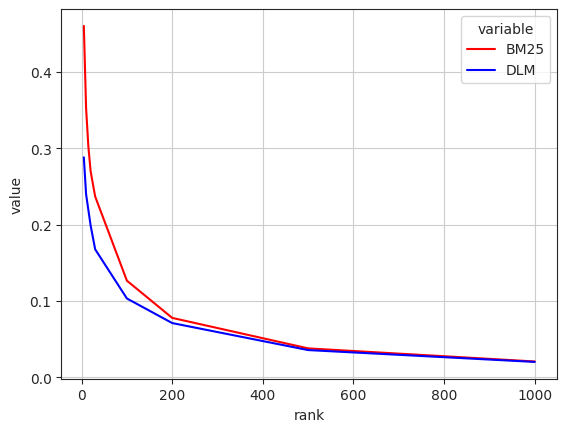

In [93]:
sns.set_style("ticks",{'axes.grid' : True})
sns.lineplot(x='rank', y='value', hue='variable', 
             data=pd.melt(df, ['rank']),
             palette=['red', 'blue'])